In [1]:
%matplotlib inline
import argparse
import csv
import logging
import os
import random
import sys
import pickle
import time
import numpy as np
from termcolor import colored
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from bert_util import *

In [2]:
sst_processor = Sst2Processor()
train_examples = sst_processor.get_train_examples('data/', 10000)
test_examples = sst_processor.get_dev_examples('data/')

In [3]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
train_examples_tokens = []
for te in train_examples:
    train_examples_tokens.append(["[CLS]"] + bert_tokenizer.tokenize(te.text_a) + ["[SEP]"])

In [109]:
def direct_consistency(interested_test_idx, top_percentage=1.0):
    test_tok_sal_list, train_tok_sal_lists, test_pred_status = pickle.load(open("from_aws/SA_influence_output_bert_e3/saliency_test_" + str(interested_test_idx) + ".pkl", "rb"))
#     test_tok_sal_list, train_tok_sal_lists, test_pred_status = pickle.load(open("from_aws/SA_diff_influence_output_bert_e3_smsal/saliency_test_" + str(interested_test_idx) + ".pkl", "rb"))
    for te in test_examples:
        if te.guid == interested_test_idx:
            break
    
    if test_pred_status == 'correct':
        test_pred_label = te.label
    else:
        if te.label == '0':
            test_pred_label = '1'
        elif te.label == '1':
            test_pred_label = '0'
        else:
            raise ValueError("Check label set.")
            
    orig_influences = pickle.load(open("from_aws/SA_influence_output_bert_e3/influences_test_" + str(interested_test_idx) + ".pkl", "rb"))
    orig_influences = stats.zscore(orig_influences)
    train_idx_sorted = list(np.argsort(orig_influences))
    train_idx_sorted.reverse()
    
    diff_influences_list, mask_ix = pickle.load(open("from_aws/SA_diff_influence_output_bert_e3/diff_mask_influences_test_" + str(interested_test_idx) + ".pkl", "rb"))
#     diff_influences_list, mask_ix = pickle.load(open("from_aws/SA_diff_influence_output_bert_e3_smsal/diff_mask_influences_test_" + str(interested_test_idx) + ".pkl", "rb"))
    
    mean_ranks = [None, None, None, None, None]
    for remove_token_type in (0, 1, 2, 3, 4):
        sal_token = test_tok_sal_list[mask_ix[remove_token_type]][0]
        sal_token_ranks = []
        for _i, idx in enumerate(train_idx_sorted):
            tet = train_examples_tokens[idx]
            if train_examples[idx].label != test_pred_label:
                continue
            if _i >= len(orig_influences) * top_percentage:
                break
            if sal_token in tet:
#                 sal_token_ranks.append(_i)
                sal_token_ranks.append(orig_influences[idx])
#         mean_ranks[remove_token_type] = [np.nanmean(sal_token_ranks)]
        mean_ranks[remove_token_type] = sal_token_ranks
    return mean_ranks

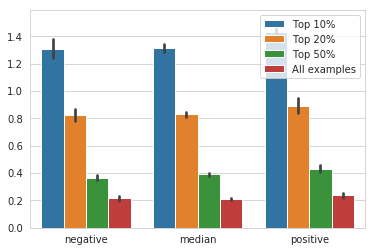

In [110]:
top_percentage = 0.1

idx_range = range(1, 51)
mean_ranks_lists = [[], [], [], [], []]
for iti in idx_range:
    mean_ranks = direct_consistency(iti, top_percentage)
    for i, mean_rank in enumerate(mean_ranks):
        mean_ranks_lists[i].extend(mean_rank)

sns_x_1 = ["negative"]*len(mean_ranks_lists[0])+["median"]*len(mean_ranks_lists[1])+["positive"]*len(mean_ranks_lists[2])
sns_y_1 = mean_ranks_lists[0]+mean_ranks_lists[1]+mean_ranks_lists[2]

top_percentage = 0.2

idx_range = range(1, 51)
mean_ranks_lists = [[], [], [], [], []]
for iti in idx_range:
    mean_ranks = direct_consistency(iti, top_percentage)
    for i, mean_rank in enumerate(mean_ranks):
        mean_ranks_lists[i].extend(mean_rank)

sns_x_2 = ["negative"]*len(mean_ranks_lists[0])+["median"]*len(mean_ranks_lists[1])+["positive"]*len(mean_ranks_lists[2])
sns_y_2 = mean_ranks_lists[0]+mean_ranks_lists[1]+mean_ranks_lists[2]

top_percentage = 0.5

idx_range = range(1, 51)
mean_ranks_lists = [[], [], [], [], []]
for iti in idx_range:
    mean_ranks = direct_consistency(iti, top_percentage)
    for i, mean_rank in enumerate(mean_ranks):
        mean_ranks_lists[i].extend(mean_rank)

sns_x_3 = ["negative"]*len(mean_ranks_lists[0])+["median"]*len(mean_ranks_lists[1])+["positive"]*len(mean_ranks_lists[2])
sns_y_3 = mean_ranks_lists[0]+mean_ranks_lists[1]+mean_ranks_lists[2]

top_percentage = 1.0

idx_range = range(1, 51)
mean_ranks_lists = [[], [], [], [], []]
for iti in idx_range:
    mean_ranks = direct_consistency(iti, top_percentage)
    for i, mean_rank in enumerate(mean_ranks):
        mean_ranks_lists[i].extend(mean_rank)

sns_x_4 = ["negative"]*len(mean_ranks_lists[0])+["median"]*len(mean_ranks_lists[1])+["positive"]*len(mean_ranks_lists[2])
sns_y_4 = mean_ranks_lists[0]+mean_ranks_lists[1]+mean_ranks_lists[2]

sns_total_x = sns_x_1 + sns_x_2 + sns_x_3 + sns_x_4
sns_total_y = sns_y_1 + sns_y_2 + sns_y_3 + sns_y_4
sns_hue = ["Top 10%"]*len(sns_x_1) + ["Top 20%"]*len(sns_x_2) + ["Top 50%"]*len(sns_x_3) + ["All examples"]*len(sns_x_4)

g = sns.barplot(x=sns_total_x, y=sns_total_y, hue=sns_hue)

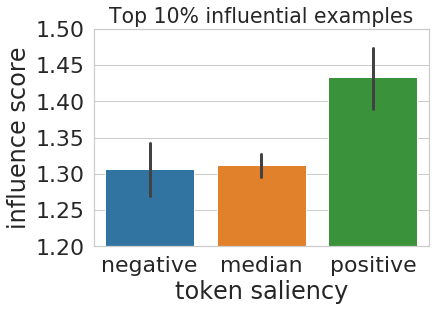

1.3064390240827972
1.3118395242026446
1.4334428519878222
1.372634153371109
1.3232047659606343

0.0364729687139612
0.015768960064398475
0.040927017327438996
0.01618137429186537
0.021157783510877187


In [111]:
sub_top_percentage = 0.1

idx_range = range(1, 51)
sub_mean_ranks_lists = [[], [], [], [], []]
for iti in idx_range:
    mean_ranks = direct_consistency(iti, sub_top_percentage)
    for i, mean_rank in enumerate(mean_ranks):
#         mean_ranks_lists[i].append(mean_rank)
        sub_mean_ranks_lists[i].extend(mean_rank)
    
sns.set_style("whitegrid")
with sns.plotting_context("notebook", font_scale=2):
    ax1 = sns.barplot(x=["negative"]*len(sub_mean_ranks_lists[0])+["median"]*len(sub_mean_ranks_lists[1])+["positive"]*len(sub_mean_ranks_lists[2]),
                  y=sub_mean_ranks_lists[0]+sub_mean_ranks_lists[1]+sub_mean_ranks_lists[2], ci=68, errwidth=3)
with sns.plotting_context("notebook", font_scale=1.7):
    plt.title("Top 10% influential examples")
ax1.set_ylabel('influence score')
ax1.set_xlabel('token saliency')
ax1.set(ylim=(1.2, 1.5)) # control for y-lim
plt.show()

print(np.mean(sub_mean_ranks_lists[0]))
print(np.mean(sub_mean_ranks_lists[1]))
print(np.mean(sub_mean_ranks_lists[2]))
print(np.mean(sub_mean_ranks_lists[3]))
print(np.mean(sub_mean_ranks_lists[4]))
print()
print(stats.sem(sub_mean_ranks_lists[0]))
print(stats.sem(sub_mean_ranks_lists[1]))
print(stats.sem(sub_mean_ranks_lists[2]))
print(stats.sem(sub_mean_ranks_lists[3]))
print(stats.sem(sub_mean_ranks_lists[4]))

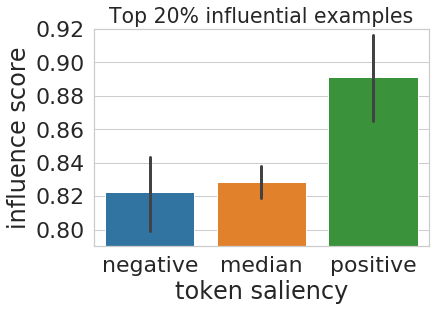

0.8225385616824215
0.8283842023900355
0.8910168084757774
0.8525158029421869
0.8417689548193203

0.02236659053221041
0.01010955531754353
0.025706382691982242
0.01036167467266842
0.013165292352029496


In [112]:
sub_top_percentage = 0.2

idx_range = range(1, 51)
sub_mean_ranks_lists = [[], [], [], [], []]
for iti in idx_range:
    mean_ranks = direct_consistency(iti, sub_top_percentage)
    for i, mean_rank in enumerate(mean_ranks):
#         mean_ranks_lists[i].append(mean_rank)
        sub_mean_ranks_lists[i].extend(mean_rank)
    
sns.set_style("whitegrid")
with sns.plotting_context("notebook", font_scale=2):
    ax1 = sns.barplot(x=["negative"]*len(sub_mean_ranks_lists[0])+["median"]*len(sub_mean_ranks_lists[1])+["positive"]*len(sub_mean_ranks_lists[2]),
                  y=sub_mean_ranks_lists[0]+sub_mean_ranks_lists[1]+sub_mean_ranks_lists[2], ci=68, errwidth=3)
with sns.plotting_context("notebook", font_scale=1.7):
    plt.title("Top 20% influential examples")
ax1.set_ylabel('influence score')
ax1.set_xlabel('token saliency')
ax1.set(ylim=(0.79, 0.92)) # control for y-lim
plt.show()

print(np.mean(sub_mean_ranks_lists[0]))
print(np.mean(sub_mean_ranks_lists[1]))
print(np.mean(sub_mean_ranks_lists[2]))
print(np.mean(sub_mean_ranks_lists[3]))
print(np.mean(sub_mean_ranks_lists[4]))
print()
print(stats.sem(sub_mean_ranks_lists[0]))
print(stats.sem(sub_mean_ranks_lists[1]))
print(stats.sem(sub_mean_ranks_lists[2]))
print(stats.sem(sub_mean_ranks_lists[3]))
print(stats.sem(sub_mean_ranks_lists[4]))

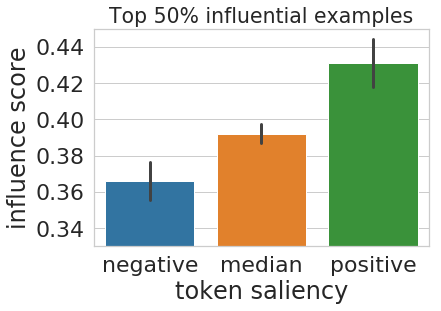

0.365804516520108
0.391892726266455
0.43143477402689734
0.38866619136945235
0.39910279884489347

0.010708015978119578
0.005203548676613808
0.013291333963204725
0.005170975547479759
0.0066853310340886695


In [113]:
sub_top_percentage = 0.5

idx_range = range(1, 51)
sub_mean_ranks_lists = [[], [], [], [], []]
for iti in idx_range:
    mean_ranks = direct_consistency(iti, sub_top_percentage)
    for i, mean_rank in enumerate(mean_ranks):
#         mean_ranks_lists[i].append(mean_rank)
        sub_mean_ranks_lists[i].extend(mean_rank)

sns.set_style("whitegrid")
with sns.plotting_context("notebook", font_scale=2):
    ax1 = sns.barplot(x=["negative"]*len(sub_mean_ranks_lists[0])+["median"]*len(sub_mean_ranks_lists[1])+["positive"]*len(sub_mean_ranks_lists[2]),
                  y=sub_mean_ranks_lists[0]+sub_mean_ranks_lists[1]+sub_mean_ranks_lists[2], ci=68, errwidth=3)
with sns.plotting_context("notebook", font_scale=1.7):
    plt.title("Top 50% influential examples")
ax1.set_ylabel('influence score')
ax1.set_xlabel('token saliency')
ax1.set(ylim=(0.33, 0.45)) # control for y-lim
plt.show()

print(np.mean(sub_mean_ranks_lists[0]))
print(np.mean(sub_mean_ranks_lists[1]))
print(np.mean(sub_mean_ranks_lists[2]))
print(np.mean(sub_mean_ranks_lists[3]))
print(np.mean(sub_mean_ranks_lists[4]))
print()
print(stats.sem(sub_mean_ranks_lists[0]))
print(stats.sem(sub_mean_ranks_lists[1]))
print(stats.sem(sub_mean_ranks_lists[2]))
print(stats.sem(sub_mean_ranks_lists[3]))
print(stats.sem(sub_mean_ranks_lists[4]))

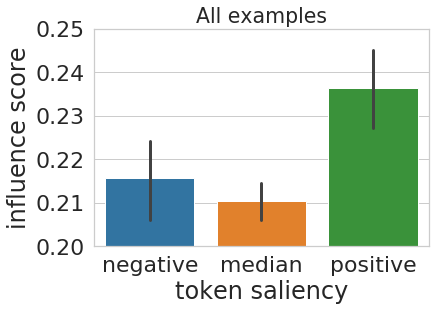

0.21570429763332627
0.21032062303379184
0.23643617578854687
0.24092168938254457
0.2546574595836357

0.009055257902951194
0.0042435262622985345
0.008999284565924979
0.004127971983124223
0.005828392457954118


In [114]:
top_percentage = 1.0

idx_range = range(1, 51)
mean_ranks_lists = [[], [], [], [], []]
for iti in idx_range:
    mean_ranks = direct_consistency(iti, top_percentage)
    for i, mean_rank in enumerate(mean_ranks):
#         mean_ranks_lists[i].append(mean_rank)
        mean_ranks_lists[i].extend(mean_rank)

sns.set_style("whitegrid")
with sns.plotting_context("notebook", font_scale=2):
    ax1 = sns.barplot(x=["negative"]*len(mean_ranks_lists[0])+["median"]*len(mean_ranks_lists[1])+["positive"]*len(mean_ranks_lists[2]),
                  y=mean_ranks_lists[0]+mean_ranks_lists[1]+mean_ranks_lists[2], ci=68, errwidth=3)
with sns.plotting_context("notebook", font_scale=1.7):
    plt.title("All examples")
ax1.set_ylabel('influence score')
ax1.set_xlabel('token saliency')
ax1.set(ylim=(0.2, 0.25)) # control for y-lim
plt.show()

print(np.mean(mean_ranks_lists[0]))
print(np.mean(mean_ranks_lists[1]))
print(np.mean(mean_ranks_lists[2]))
print(np.mean(mean_ranks_lists[3]))
print(np.mean(mean_ranks_lists[4]))
print()
print(stats.sem(mean_ranks_lists[0]))
print(stats.sem(mean_ranks_lists[1]))
print(stats.sem(mean_ranks_lists[2]))
print(stats.sem(mean_ranks_lists[3]))
print(stats.sem(mean_ranks_lists[4]))